In [0]:
#creating SparkSession

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('TDSQL').getOrCreate()

In [0]:
#creating dataframe
df = spark.read.csv('/FileStore/tables/taxi_data.csv',inferSchema=True,header=True)

In [0]:
data=df.dropna()
data.count()

Out[3]: 995134

In [0]:
#Converted Date columns from StringType to timestamp 
from pyspark.sql.functions import *

spark.conf.set("spark.sql.legacy.timeParserPolicy", "Legacy")
data=data.withColumn('tpep_pickup_datetime',to_timestamp(data.tpep_pickup_datetime, 'MM/dd/yyyy HH:mm')).\
        withColumn('tpep_dropoff_datetime',to_timestamp(data.tpep_dropoff_datetime, 'MM/dd/yyyy HH:mm'))

In [0]:
import pyspark.sql.functions as f

# Engineered features
# Get rid of 27 categories into a dummy for condition. bad conditions include any of the categories below
# Temperature should only make a difference when causes an inconvenience/discomfort
# Get date, year, month, hour, day from tpep_pickup to perform analysis 
# Get trip duration and Covid

data = data.withColumn("good_condition", when(f.col("condition") == "Snow", 0) \
                        .when(f.col("condition") == "Rain / Windy", 0) \
                        .when(f.col("condition") == "Heavy Rain", 0) \
                        .when(f.col("condition") == "Rain", 0) \
                        .when(f.col("condition") == "Heavy T-Storm", 0) \
                        .when(f.col("condition") == "Thunder in the Vicinity", 0) \
                        .when(f.col("condition") == "Thunder", 0) \
                        .when(f.col("condition") == "Light Rain with Thunder", 0) \
                        .when(f.col("condition") == "Thunder / Windy", 0) \
                        .when(f.col("condition") == "T-Storm", 0) \
                        .otherwise(1)) \
            .withColumn("extreme_temp", when((f.col("temperature") > 86) | (f.col("temperature") < 21), 1).otherwise(0)) \
            .withColumn('date',to_date(data.tpep_pickup_datetime)) \
            .withColumn('year',year(data.tpep_pickup_datetime)) \
            .withColumn('month',month(data.tpep_pickup_datetime)) \
            .withColumn('hour', hour(data.tpep_pickup_datetime)) \
            .withColumn('day', dayofweek(data.tpep_pickup_datetime)) \
            .withColumn('trip_time', unix_timestamp(data.tpep_dropoff_datetime) - unix_timestamp(data.tpep_pickup_datetime)) \
            .withColumn('covid', when(f.col("tpep_pickup_datetime") > "2020-03-08 00:00:00", 1).otherwise(0)) 

data.show(1) 

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+--------------+----------+---------+-------+------------+--------------+----------+--------------+----------+---------+-------+------------+--------------+-----------+-----------+--------+----------+--------+------+----------+--------------+------------+----------+----+-----+----+---+---------+-----+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|borough_pu|median_rlst_pu|tourist_pu|entert_pu|park_pu|workplace_pu|residential_pu|borough_do|median_rlst_do|tourist_do|entert_do|park_do|workplace_do|residential_do|  rat

In [0]:
data=data.filter("fare_amount > 2.5")
data.count()

Out[6]: 994464

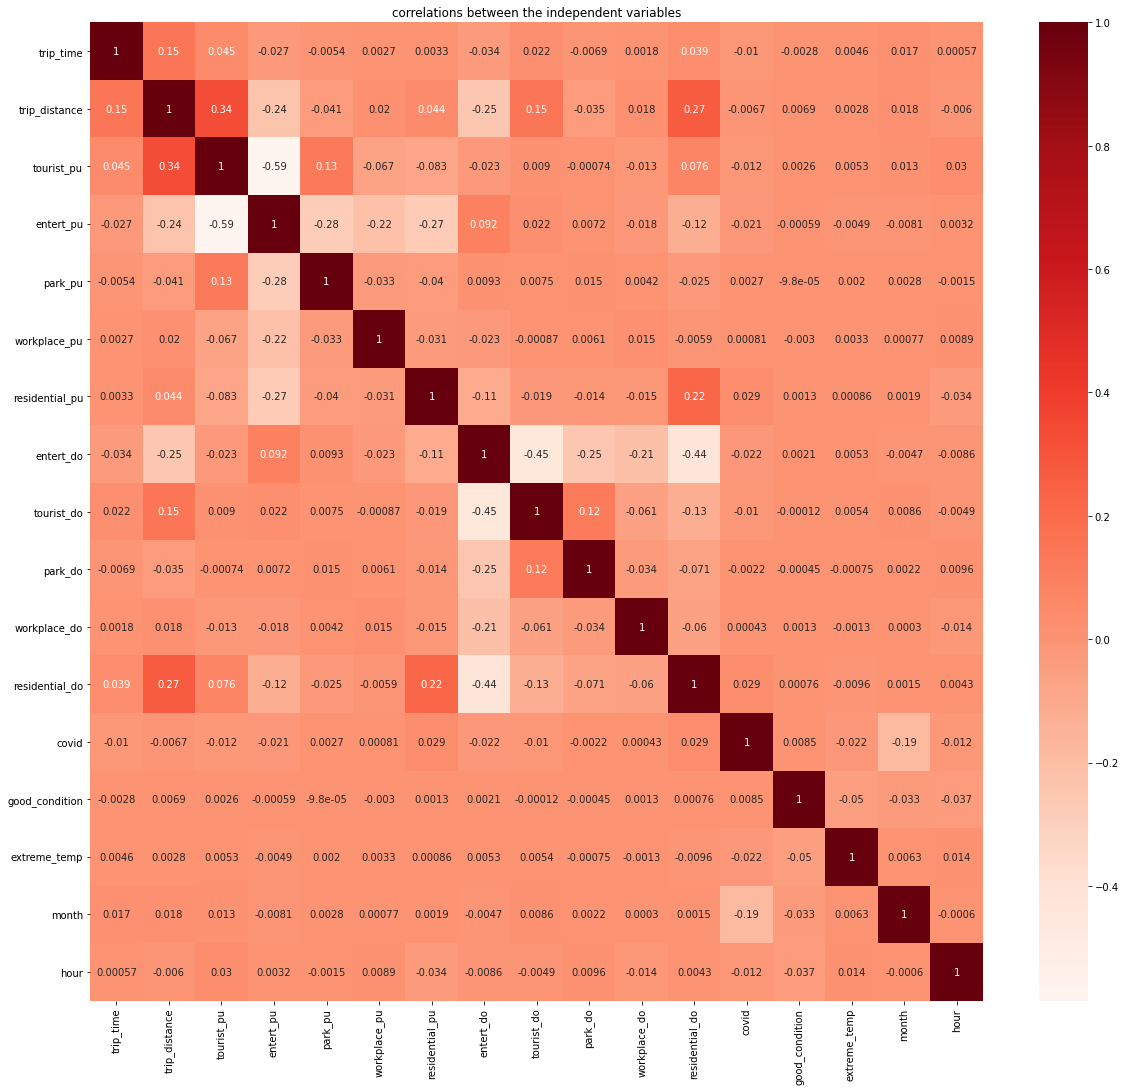

In [0]:
#Check the correlations between the independent variables 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(20,18))
plt.title("correlations between the independent variables")

#Selecting independent variables and checking Correlation

data_cor = data.select(["trip_time",'trip_distance','borough_pu','tourist_pu','entert_pu','park_pu','workplace_pu','residential_pu','borough_do','entert_do','tourist_do','park_do','workplace_do','residential_do', 'covid',"good_condition","extreme_temp",'month',"hour"])
data_p = data_cor.toPandas()
cor = data_p.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [0]:
# Create a 70-30 train test split

train_data,test_data=data.randomSplit([0.7,0.3])

In [0]:
# Import the required libraries

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline

In [0]:
# Use StringIndexer to convert the categorical columns to hold numerical data

borough_pu_indexer = StringIndexer(inputCol='borough_pu',outputCol='borough_pu_index',handleInvalid='keep')
borough_do_indexer = StringIndexer(inputCol='borough_do',outputCol='borough_do_index',handleInvalid='keep')


In [0]:
assembler = VectorAssembler(inputCols=["trip_time",'trip_distance','borough_pu_index',
                                       'tourist_pu','entert_pu','park_pu','workplace_pu','residential_pu',
                                       'borough_do_index',
                                       'tourist_do','entert_do','park_do','workplace_do','residential_do',
                                       'covid',"good_condition","extreme_temp",'month',"hour"],
                            outputCol="features")

In [0]:
# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[borough_pu_indexer,borough_do_indexer,assembler])

In [0]:
fitted_pipe=pipe.fit(train_data)

In [0]:
train_data=fitted_pipe.transform(train_data)

In [0]:
# Create an object for the Linear Regression model

lr_model = LinearRegression(labelCol='fare_amount')

# Fit the model on the train data

fit_model = lr_model.fit(train_data.select(['features','fare_amount']))

# Transform the test data using the model to predict the duration

test_data=fitted_pipe.transform(test_data)

# Store the results in a dataframe

results = fit_model.transform(test_data)

results.select(['features','fare_amount','prediction']).show()

+--------------------+-----------+------------------+
|            features|fare_amount|        prediction|
+--------------------+-----------+------------------+
|(19,[0,1,4,8,13,1...|       20.0|22.507579476232266|
|(19,[0,1,4,9,15,1...|        8.0| 9.807484884056613|
|(19,[0,1,4,9,15,1...|        6.5| 7.942455664924932|
|(19,[0,1,8,9,15,1...|       52.0| 63.87327534968864|
|(19,[0,1,7,10,15,...|       13.0|14.052843756110136|
|(19,[0,1,4,10,15,...|       10.0|   9.2290889645572|
|(19,[0,1,4,9,15,1...|        7.5| 8.049361649963124|
|(19,[0,1,15,17,18...|        7.0| 6.369992507675194|
|(19,[0,1,10,15,17...|        7.0| 7.758761093819729|
|(19,[0,1,3,10,15,...|        7.0|7.5158632751392735|
|(19,[0,1,7,10,15,...|        4.0| 7.790710720036881|
|(19,[0,1,10,15,17...|        6.5| 6.961800357783526|
|(19,[0,1,4,15,17,...|       10.5|10.069024210024635|
|(19,[0,1,4,13,15,...|        7.5| 5.789229146136815|
|(19,[0,1,4,15,17,...|        6.0| 7.871483994316073|
|(19,[0,1,5,10,15,...|      

In [0]:
test_results = fit_model.evaluate(test_data)
test_results.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -2.507579476232266|
|-1.8074848840566133|
|-1.4424556649249318|
| -11.87327534968864|
|-1.0528437561101356|
| 0.7709110354428006|
|-0.5493616499631244|
| 0.6300074923248058|
|-0.7587610938197287|
|-0.5158632751392735|
|-3.7907107200368806|
|-0.4618003577835257|
|0.43097578997536523|
| 1.7107708538631847|
|-1.8714839943160726|
|-1.0544771877618615|
| -2.693525376164483|
| 1.2388233357322065|
|-0.6392091882408621|
| 0.7106165855767124|
+-------------------+
only showing top 20 rows



#### co-efficients

In [0]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(fit_model.coefficients))
print("Intercept: %s" % str(fit_model.intercept))

Coefficients: [5.974633173823792e-05,2.7110774705927607,-0.22995031608020805,0.028209928378820838,0.38792026802481483,0.4611817118407998,0.13176019691526059,1.95121253505785,1.9226357288581264,-0.328028048283953,0.03681463075244762,-0.12173988103761783,-0.1810452784877268,-2.3605321550471223,-0.7875404154746272,-0.4097364415985146,0.26696298215688186,0.051774187419916996,0.019947285045920724]
Intercept: 4.3277141084133435


In [0]:
"trip_time",          6.114149896149661e05
'trip_distance',      2.7093481777890234
                                                        'borough_pu_index',   -0.26786575982580296                                    
'tourist_pu',         0.05152748712426076
'entert_pu',          0.4069612238193823
'park_pu',            0.47547555151563126
'workplace_pu',       0.14793792435927955
'residential_pu',     1.974718776368855
'borough_do_index',   1.917210233512411                                    
                                                        'tourist_do',         -0.33718710206210617
'entert_do',          0.036903907828124805
                                                        'park_do',            -0.12563895955231552
                                                        'workplace_do',       -0.17886263230170968
                                                        'residential_do',     -2.333176639958813                                  
                                                        'covid',              -0.8088218912941378
                                                        "good_condition",     -0.44405649025862265
"extreme_temp",       0.26073976077276967
'month',              0.052811569481462185
"hour"                0.019478220651093833



#### Evaluation

In [0]:
test_results.rootMeanSquaredError

Out[60]: 4.0499427615754096

##### The root mean squared error is low indicating that the models prediction is really on the better side

In [0]:
test_results.r2

Out[61]: 0.8780895436325387

##### The r-squared value implies that the model explains only about 87% variance

#### Decision tree regression

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'fare_amount')
dt_model = dt.fit(train_data.select(['features','fare_amount']))
dt_predictions = dt_model.transform(test_data)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
dt_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % dt_rmse)

Root Mean Squared Error (RMSE) on test data = 3.58284


In [0]:
dt_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
dt_r2 = dt_evaluator.evaluate(dt_predictions)
print("R2 on test data = %g" % dt_r2)

R2 on test data = 0.904589


In [0]:
dt_model.featureImportances

Out[73]: SparseVector(19, {0: 0.1421, 1: 0.8185, 2: 0.0039, 7: 0.0004, 8: 0.0351})

In [0]:
"trip_time",
'trip_distance',
    'borough_pu_index',                                       
                    'tourist_pu',
                    'entert_pu',
                    'park_pu',
                    'workplace_pu',
    'residential_pu',
'borough_do_index',                                       
'tourist_do',
                    'entert_do',
                    'park_do',
                    'workplace_do',
                    'residential_do',                                       
                    'covid',
                    "good_condition",
                    "extreme_temp",
            'month',
                    "hour"

#### Gradient-boosted tree regression

In [0]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'fare_amount', maxIter=10)
gbt_model = gbt.fit(train_data.select(['features','fare_amount']))
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'fare_amount', 'features').show(5)

+------------------+-----------+--------------------+
|        prediction|fare_amount|            features|
+------------------+-----------+--------------------+
|22.182651456219503|       20.0|(19,[0,1,4,8,13,1...|
|  7.28179259504427|        8.0|(19,[0,1,4,9,15,1...|
| 5.591366250563546|        6.5|(19,[0,1,4,9,15,1...|
|52.544397426455774|       52.0|(19,[0,1,8,9,15,1...|
|14.032179961136523|       13.0|(19,[0,1,7,10,15,...|
+------------------+-----------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.33456


In [0]:
gbt_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
gbt_r2 = gbt_evaluator.evaluate(gbt_predictions)
print("R2 on test data = %g" % gbt_r2)

R2 on test data = 0.917354


In [0]:
gbt_model.featureImportances

Out[65]: SparseVector(19, {0: 0.1805, 1: 0.7096, 2: 0.0366, 3: 0.0023, 4: 0.0003, 5: 0.0006, 7: 0.0065, 8: 0.0492, 9: 0.0001, 12: 0.0, 13: 0.0093, 15: 0.0008, 16: 0.0007, 17: 0.0006, 18: 0.003})

In [0]:
"trip_time",
'trip_distance',
    'borough_pu_index',                                       
        'tourist_pu',
            'entert_pu',
            'park_pu',
                        'workplace_pu',
        'residential_pu',
    'borough_do_index',                                       
            'tourist_do',
                                                             'entert_do',
                                                             'park_do',
                                                        'workplace_do',
    'residential_do',                                       
                                                             'covid',
            "good_condition",
            "extreme_temp",
            'month',
    "hour"

#### Random Forest Regressor

In [0]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor(featuresCol = 'features', labelCol = 'fare_amount')
rfr_model = rfr.fit(train_data.select(['features','fare_amount']))
rfr_predictions = rfr_model.transform(test_data)
rfr_predictions.select('prediction', 'fare_amount', 'features').show(5)

+------------------+-----------+--------------------+
|        prediction|fare_amount|            features|
+------------------+-----------+--------------------+
|21.220907907913972|       20.0|(19,[0,1,4,8,13,1...|
| 7.921139614013763|        8.0|(19,[0,1,4,9,15,1...|
|  7.02175375024814|        6.5|(19,[0,1,4,9,15,1...|
|50.517364757505604|       52.0|(19,[0,1,8,9,15,1...|
| 13.39942972684375|       13.0|(19,[0,1,7,10,15,...|
+------------------+-----------+--------------------+
only showing top 5 rows



In [0]:
rfr_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rfr_rmse = rfr_evaluator.evaluate(rfr_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rfr_rmse)

Root Mean Squared Error (RMSE) on test data = 3.64434


In [0]:
rfr_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
rfr_r2 = rfr_evaluator.evaluate(rfr_predictions)
print("R2 on test data = %g" % rfr_r2)

R2 on test data = 0.901286


In [0]:
rfr_model.featureImportances

Out[69]: SparseVector(19, {0: 0.2961, 1: 0.4409, 2: 0.1469, 3: 0.0011, 4: 0.0001, 5: 0.0, 6: 0.0001, 7: 0.0011, 8: 0.1019, 9: 0.0044, 10: 0.0037, 12: 0.0, 13: 0.0029, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0007})

In [0]:
"trip_time",
'trip_distance',
'borough_pu_index',                                       
        'tourist_pu',
            'entert_pu',
                            'park_pu',
            'workplace_pu',
    'residential_pu',
'borough_do_index',                                       
        'tourist_do',
        'entert_do',
                                          'park_do',
                            'workplace_do',
        'residential_do',                                       
                            'covid',
                                          "good_condition",
                            "extreme_temp",
                            'month',
              "hour"